In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import warnings
warnings.filterwarnings('ignore')

In [51]:
from utils import *

In [12]:
random.seed(2024)

In [18]:
data_dir='../raw_data'
filename='../raw_data/pheme/pheme_single.csv'
fig_dir=os.path.join(data_dir,'fig')

# sentiment & emotion distribution

## sentiment/emotion distribution of source tweets
- select only source tweets
- plot distribution of #comments in all tweets
- filter out source tweets with more than n_comments
- plot histogram of emotion & valence (concatenate them all and flatten them), so we get two lists for rumour & non-rumour separately

In [19]:
# filter source tweet with more than N comments
n_comments=2

df=preprocess(pd.read_csv(filename,encoding='utf-8'))
# df=df[df['event']=='ferguson']
df=df[~df['rumour_type'].str.endswith('reaction')]
df['structure']=df['structure'].apply(lambda x: collect_keys(x))
df['n_comments']=df['structure'].apply(lambda x: len(x))
# filter tweets with at least n_comments
df=df[df['n_comments']>=n_comments]

In [20]:
# source tweet sentiment distribution
rumour=df[df['rumour_type']=='rumours']
non_rumour=df[df['rumour_type']=='non-rumours']
true=rumour[rumour['factuality']=='true']
false=rumour[rumour['factuality']=='false']
unverified=rumour[rumour['factuality']=='unverified']

# sample true, false and unverified
sample_m=min(len(true),len(false),len(unverified))
true=true.sample(sample_m,random_state=2024)
false=false.sample(sample_m,random_state=2024)
unverified=unverified.sample(sample_m,random_state=2024)

# sample rumour vs non-rumour
sample_n=min(len(rumour),len(non_rumour))
rumour=rumour.sample(sample_n,random_state=2024)
non_rumour=non_rumour.sample(sample_n,random_state=2024)

print(f"true rumour size:{len(true)}")
print(f"false rumour size:{len(false)}")
print(f"unverified rumour size:{len(unverified)}")
print()
print(f"rumour size:{len(rumour)}")
print(f"non rumour size:{len(non_rumour)}")

true rumour size:505
false rumour size:505
unverified rumour size:505

rumour size:2691
non rumour size:2691


In [21]:
print(f"average sentiment for rumour:{rumour['emollm_sentiment'].mean()}")
print(f"average sentiment for non rumour:{non_rumour['emollm_sentiment'].mean()}")
print(f"average sentiment for true rumour:{true['emollm_sentiment'].mean()}")
print(f"average sentiment for false rumour:{false['emollm_sentiment'].mean()}")
print(f"average sentiment for unverified rumour:{unverified['emollm_sentiment'].mean()}")

average sentiment for rumour:-0.31735414344109997
average sentiment for non rumour:-0.23262727610553696
average sentiment for true rumour:-0.23366336633663368
average sentiment for false rumour:-0.1702970297029703
average sentiment for unverified rumour:-0.4297029702970297


In [22]:
# conduct p-test for average sentiment
pairs=[
    (rumour['emollm_sentiment'],non_rumour['emollm_sentiment']),
    (true['emollm_sentiment'],false['emollm_sentiment']),
    (unverified['emollm_sentiment'], true['emollm_sentiment']),
    (unverified['emollm_sentiment'], false['emollm_sentiment']),
]

print(f"rumour and non-rumour sentiment t-test:")
for a, b in pairs:
    # t_stat, p_value = stats.ttest_ind(a,b)
    t_stat, p_value = stats.ttest_ind(a, b, alternative='less')
    print(f"T-statistic: {t_stat}, P-value: {p_value}")

f_stat, p_value = stats.f_oneway(true['emollm_sentiment'], false['emollm_sentiment'], unverified['emollm_sentiment'])
print(f"\ntrue, false, unverified rumour sentiment ANOVA:")
print(f"F-statistic: {f_stat}, P-value: {p_value}")

rumour and non-rumour sentiment t-test:
T-statistic: -3.9518875296734244, P-value: 3.9265306026948795e-05
T-statistic: -1.353590321863798, P-value: 0.08808527505858418
T-statistic: -4.201249715809951, P-value: 1.44481233059843e-05
T-statistic: -5.4571491846409454, P-value: 3.045059697558773e-08

true, false, unverified rumour sentiment ANOVA:
F-statistic: 16.55564267370289, P-value: 7.719196480372521e-08


In [22]:
rumour_emotion = sorted(sum(rumour['emollm_emotion'].apply(process_emotion), []))
non_rumour_emotion = sorted(sum(non_rumour['emollm_emotion'].apply(process_emotion), []))
true_emotion = sorted(sum(true['emollm_emotion'].apply(process_emotion), []))
false_emotion = sorted(sum(false['emollm_emotion'].apply(process_emotion), []))
unverified_emotion = sorted(sum(unverified['emollm_emotion'].apply(process_emotion), []))

In [25]:
# all_df = sorted(sum(df['emollm_emotion'].apply(process_emotion), []))
# sns_plot2(all_df,size=(16,4),xlabels=EMO,title='all tweets emotion distribution',auto=True,saveto='all_src_emotion.pdf')

TBD event-based distribution

## sentiment/emotion distribution of source tweets + comments

In [23]:
# filter source tweet with more than N comments
n_comments=2

df=preprocess(pd.read_csv(filename,encoding='utf-8'))
df['id']=df['id'].astype(str)
src_tweets=df[~df['rumour_type'].str.endswith('reaction')]
src_tweets['n_comments']=src_tweets['structure'].apply(lambda x: collect_keys(x)).apply(lambda x: len(x))
src_tweets=src_tweets[src_tweets['n_comments']>=n_comments]

# sample same amount of cases for rumours and non-rumours
rumour=src_tweets[src_tweets['rumour_type']=='rumours']
non_rumour=src_tweets[src_tweets['rumour_type']=='non-rumours']

# sampling to balance data
sample_n=min(len(rumour),len(non_rumour))
rumour=rumour.sample(sample_n,random_state=2024)
non_rumour=non_rumour.sample(sample_n,random_state=2024)
print(f"rumour size:{len(rumour)}")
print(f"non rumour size:{len(non_rumour)}")

src_tweets=pd.concat([rumour,non_rumour])

rumour size:2691
non rumour size:2691


In [24]:
df_comments=[]
for i,(index, row) in tqdm(enumerate(src_tweets.iterrows()),total=len(src_tweets)):
    # get all comments in the source tweet thread
    structure=row['structure']
    structure_keys = collect_keys(structure,'all')
    df_thread = df[df['id'].isin(structure_keys)]
    df_thread['emollm_emotion']=df_thread['emollm_emotion'].apply(process_emotion)
    
    # aggregate each thread, 
    # get top3 emotion, average sentiment
    all_words = list(itertools.chain.from_iterable(df_thread['emollm_emotion']))
    top_3 = [word for word, count in Counter(all_words).most_common(MOST_COMMON)]
    ave_sentiment=df_thread['emollm_sentiment'].mean()
    
    # compute entropy of emotion and sentiment valence
    # sentiment_entropy=compute_entropy(df_thread['emollm_sentiment'])
    # emotion_entropy=compute_entropy(df_thread['emollm_emotion'])
    
    df_agg=pd.DataFrame({'id':df_thread.iloc[0]['id'],
                            'emollm_emotion':[top_3],
                            # 'sentiment_entropy':sentiment_entropy,
                            # 'emotion_entropy':emotion_entropy,
                            'rumour_type':df_thread.iloc[0]['rumour_type'],
                            'factuality':df_thread.iloc[0]['factuality'],
                            'emollm_sentiment':ave_sentiment})
    df_comments.append(df_agg)
df_comments=pd.concat(df_comments)

100%|███████████████████████████████████████████████████| 5382/5382 [00:20<00:00, 268.92it/s]


In [25]:
df_comments['rumour_type'].unique()

array(['rumours', 'non-rumours'], dtype=object)

In [26]:
# tweet comments (is_rumour)
rumour_comments=df_comments[df_comments['rumour_type'].str.startswith('rumours')]
non_rumour_comments=df_comments[df_comments['rumour_type'].str.startswith('non-rumours')]
print(f"rumour size:{len(rumour_comments)}")
print(f"non rumour size:{len(non_rumour_comments)}") 
print()

# tweet comments (factuality)
true_rumour_comments=rumour_comments[rumour_comments['factuality']=='true']
false_rumour_comments=rumour_comments[rumour_comments['factuality']=='false']
unverified_rumour_comments=rumour_comments[rumour_comments['factuality']=='unverified']

# balance true, false and unverified data via sampling
sample_p=min(len(true_rumour_comments),len(false_rumour_comments),len(unverified_rumour_comments))
true_rumour_comments=true_rumour_comments.sample(sample_p,random_state=2024)
false_rumour_comments=false_rumour_comments.sample(sample_p,random_state=2024)
unverified_rumour_comments=unverified_rumour_comments.sample(sample_p,random_state=2024)

print(f"true rumour size:{len(true_rumour_comments)}")
print(f"false rumour size:{len(false_rumour_comments)}")
print(f"unverified rumour size:{len(unverified_rumour_comments)}")

rumour size:2691
non rumour size:2691

true rumour size:505
false rumour size:505
unverified rumour size:505


In [27]:
print(f"average sentiment for rumour comments:{rumour_comments['emollm_sentiment'].mean()}")
print(f"average sentiment for non rumour comments:{non_rumour_comments['emollm_sentiment'].mean()}")
print(f"average sentiment for true rumour comments:{true_rumour_comments['emollm_sentiment'].mean()}")
print(f"average sentiment for false rumour comments:{false_rumour_comments['emollm_sentiment'].mean()}")
print(f"average sentiment for unverified rumour comments:{unverified_rumour_comments['emollm_sentiment'].mean()}")

average sentiment for rumour comments:-0.3841781016613636
average sentiment for non rumour comments:-0.29612228093998927
average sentiment for true rumour comments:-0.3656381094503394
average sentiment for false rumour comments:-0.2628677498527636
average sentiment for unverified rumour comments:-0.46062558328060865


In [28]:
# conduct t-test for aggregated sentiment
pairs=[
    (rumour_comments['emollm_sentiment'],non_rumour_comments['emollm_sentiment']),
    (true_rumour_comments['emollm_sentiment'],false_rumour_comments['emollm_sentiment']),
    (unverified_rumour_comments['emollm_sentiment'],true_rumour_comments['emollm_sentiment']),
    (unverified_rumour_comments['emollm_sentiment'],false_rumour_comments['emollm_sentiment']),
]

print(f"rumour and non-rumour sentiment t-test:")
for a, b in pairs:
    # t_stat, p_value = stats.ttest_ind(a,b)
    t_stat, p_value = stats.ttest_ind(a, b, alternative='less')
    print(f"T-statistic: {t_stat}, P-value: {p_value}")

f_stat, p_value = stats.f_oneway(true_rumour_comments['emollm_sentiment'], false_rumour_comments['emollm_sentiment'], unverified_rumour_comments['emollm_sentiment'])
print(f"\ntrue, false, unverified rumour sentiment ANOVA:")
print(f"F-statistic: {f_stat}, P-value: {p_value}")

rumour and non-rumour sentiment t-test:
T-statistic: -7.541912765476262, P-value: 2.7025472388622607e-14
T-statistic: -3.722882740133262, P-value: 0.00010393258256740002
T-statistic: -3.920735644619369, P-value: 4.7123892662848604e-05
T-statistic: -7.535269675379882, P-value: 5.411844282925831e-14

true, false, unverified rumour sentiment ANOVA:
F-statistic: 28.80265848171823, P-value: 5.291337473045581e-13


In [29]:
# tweet comments emotion distribution
rumour_comments_emotion = sorted(sum(rumour_comments['emollm_emotion'], []))
non_rumour_comments_emotion = sorted(sum(non_rumour_comments['emollm_emotion'], []))

# tweet comments emotion distribution
true_rumour_comments_emotion = sorted(sum(true_rumour_comments['emollm_emotion'], []))
false_rumour_comments_emotion = sorted(sum(false_rumour_comments['emollm_emotion'], []))
unverified_rumour_comments_emotion = sorted(sum(unverified_rumour_comments['emollm_emotion'], []))

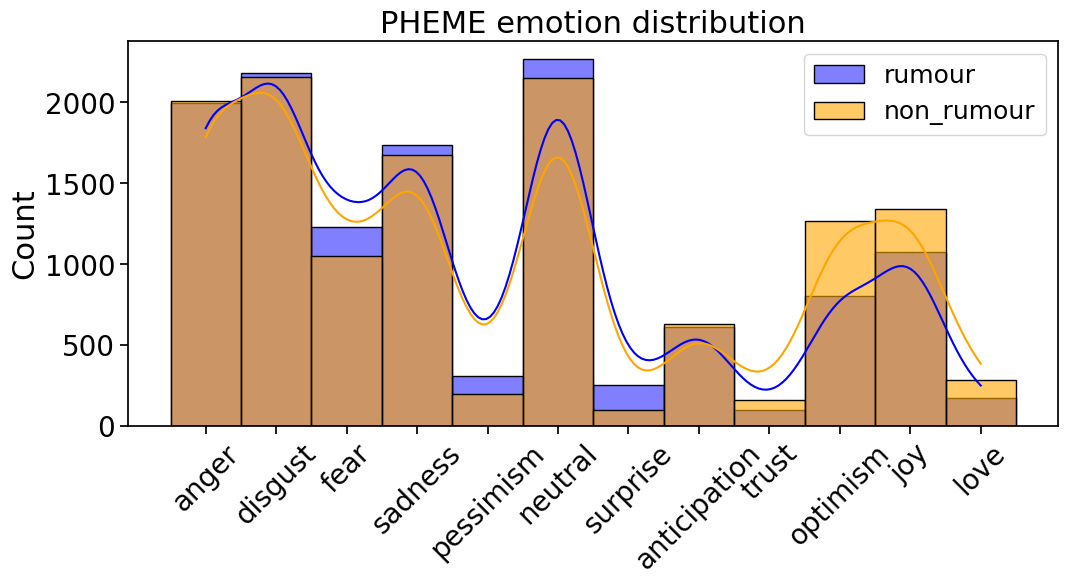

In [31]:
sns_plot2(df1=rumour_comments_emotion,df2=non_rumour_comments_emotion,size=(12,5),font_size=22,xlabels=EMO,
         title='PHEME emotion distribution',saveto='pheme_emotion.pdf')

## sentiment/emotion distribution of comments

In [32]:
# filter source tweet with more than N comments
n_comments=2

df=preprocess(pd.read_csv(filename,encoding='utf-8'))
df['id']=df['id'].astype(str)
src_tweets=df[~df['rumour_type'].str.endswith('reaction')]
src_tweets['n_comments']=src_tweets['structure'].apply(lambda x: collect_keys(x)).apply(lambda x: len(x))
src_tweets=src_tweets[src_tweets['n_comments']>=n_comments]

# sample same amount of cases for rumours and non-rumours
rumour=src_tweets[src_tweets['rumour_type']=='rumours']
non_rumour=src_tweets[src_tweets['rumour_type']=='non-rumours']

# sampling to balance data
sample_n=min(len(rumour),len(non_rumour))
rumour=rumour.sample(sample_n,random_state=2024)
non_rumour=non_rumour.sample(sample_n,random_state=2024)
print(f"rumour size:{len(rumour)}")
print(f"non rumour size:{len(non_rumour)}")

src_tweets=pd.concat([rumour,non_rumour])

rumour size:2691
non rumour size:2691


In [33]:
# cnt=0
df_comments=[]
for i,(index, row) in tqdm(enumerate(src_tweets.iterrows()),total=len(src_tweets)):
    # get all comments in the source tweet thread
    structure=row['structure']
    structure_keys = collect_keys(structure)
    df_thread = df[df['id'].isin(structure_keys)]
    df_comment=df_thread[df_thread['structure'].str.endswith('reaction')] # exclude the root tweet
    df_comment['emollm_emotion']=df_comment['emollm_emotion'].apply(process_emotion)
    
    # aggregate each thread, 
    # get top3 emotion, average sentiment
    all_words = list(itertools.chain.from_iterable(df_comment['emollm_emotion']))
    top_3 = [word for word, count in Counter(all_words).most_common(MOST_COMMON)]
    ave_sentiment=df_thread['emollm_sentiment'][1:].mean() # exclude the root tweet sentiment
    
    df_agg=pd.DataFrame({'id':df_thread.iloc[0]['id'],
                            'emollm_emotion':[top_3],
                            'rumour_type':df_thread.iloc[0]['rumour_type'],
                            'factuality':df_thread.iloc[0]['factuality'],
                            'emollm_sentiment':ave_sentiment})
    df_comments.append(df_agg)
    # cnt+=1
    # if cnt==3:
    #     break
df_comments=pd.concat(df_comments)

100%|███████████████████████████████████████████████████| 5382/5382 [00:20<00:00, 256.66it/s]


In [34]:
# df_comments['rumour_type'].unique()
# print(df_thread.iloc[0]['structure'])
# df_thread=df_thread[df_thread['structure'].str.endswith('reaction')]
df_comments

,id,emollm_emotion,rumour_type,factuality,emollm_sentiment
0,552790371848040449,"[disgust, anger, neutral, anticipation, pessim...",rumours,unverified,-0.461538
0,544332613532811264,"[neutral, joy, optimism]",rumours,true,0.000000
0,500303431928922113,"[disgust, anger, neutral, sadness, joy]",rumours,unverified,-0.666667
0,544385829180035072,"[disgust, anger, neutral, fear, sadness]",rumours,true,-0.422222
0,500370960093302784,"[disgust, anger, neutral, sadness, anticipation]",rumours,unverified,-0.875000
...,...,...,...,...,...
0,499568802267672576,"[disgust, anger, neutral, fear, sadness]",non-rumours,NaN,-0.181818
0,500183912384319489,"[neutral, optimism, joy, anger, disgust]",non-rumours,NaN,0.166667
0,553590811355795456,"[joy, neutral, optimism]",non-rumours,NaN,0.800000
0,498285405142540289,"[disgust, sadness, anger, neutral, fear]",non-rumours,NaN,-0.160000


In [35]:
df_comments['emollm_sentiment'].fillna(0,inplace=True)
df_comments[df_comments['emollm_sentiment'].isna()==True]

,id,emollm_emotion,rumour_type,factuality,emollm_sentiment


In [36]:
# tweet comments (is_rumour)
rumour_comments=df_comments[df_comments['rumour_type'].str.startswith('rumours')]
non_rumour_comments=df_comments[df_comments['rumour_type'].str.startswith('non-rumours')]
print(f"rumour size:{len(rumour_comments)}")
print(f"non rumour size:{len(non_rumour_comments)}")
print()

# tweet comments (factuality)
true_rumour_comments=rumour_comments[rumour_comments['factuality']=='true']
false_rumour_comments=rumour_comments[rumour_comments['factuality']=='false']
unverified_rumour_comments=rumour_comments[rumour_comments['factuality']=='unverified']

# balance true, false and unverified data via sampling
sample_p=min(len(true_rumour_comments),len(false_rumour_comments),len(unverified_rumour_comments))
true_rumour_comments=true_rumour_comments.sample(sample_p,random_state=2024)
false_rumour_comments=false_rumour_comments.sample(sample_p,random_state=2024)
unverified_rumour_comments=unverified_rumour_comments.sample(sample_p,random_state=2024)

print(f"true rumour size:{len(true_rumour_comments)}")
print(f"false rumour size:{len(false_rumour_comments)}")
print(f"unverified rumour size:{len(unverified_rumour_comments)}")

rumour size:2691
non rumour size:2691

true rumour size:505
false rumour size:505
unverified rumour size:505


In [37]:
print(f"average sentiment for rumour comments:{rumour_comments['emollm_sentiment'].mean()}")
print(f"average sentiment for non rumour comments:{non_rumour_comments['emollm_sentiment'].mean()}")
print(f"average sentiment for true rumour comments:{true_rumour_comments['emollm_sentiment'].mean()}")
print(f"average sentiment for false rumour comments:{false_rumour_comments['emollm_sentiment'].mean()}")
print(f"average sentiment for unverified rumour comments:{unverified_rumour_comments['emollm_sentiment'].mean()}")

average sentiment for rumour comments:-0.39397895846776987
average sentiment for non rumour comments:-0.3047555106881995
average sentiment for true rumour comments:-0.3672679837619228
average sentiment for false rumour comments:-0.2774476366266918
average sentiment for unverified rumour comments:-0.46171409834750865


In [38]:
# conduct p-test for average sentiment
pairs=[
    (rumour_comments['emollm_sentiment'],non_rumour_comments['emollm_sentiment']),
    (true_rumour_comments['emollm_sentiment'],false_rumour_comments['emollm_sentiment']),
    (unverified_rumour_comments['emollm_sentiment'],true_rumour_comments['emollm_sentiment']),
    (unverified_rumour_comments['emollm_sentiment'],false_rumour_comments['emollm_sentiment']),
]

print(f"rumour and non-rumour sentiment t-test:")
for a, b in pairs:
    # t_stat, p_value = stats.ttest_ind(a,b)
    t_stat, p_value = stats.ttest_ind(a, b, alternative='less')
    print(f"T-statistic: {t_stat}, P-value: {p_value}")

f_stat, p_value = stats.f_oneway(true_rumour_comments['emollm_sentiment'], false_rumour_comments['emollm_sentiment'], unverified_rumour_comments['emollm_sentiment'])
print(f"\ntrue, false, unverified rumour sentiment ANOVA:")
print(f"F-statistic: {f_stat}, P-value: {p_value}")

rumour and non-rumour sentiment t-test:
T-statistic: -7.262473361185691, P-value: 2.1712881684933106e-13
T-statistic: -2.847868243048825, P-value: 0.002245372464134492
T-statistic: -3.6302764569662234, P-value: 0.00014867513476155347
T-statistic: -6.383077001127384, P-value: 1.3215256556228386e-10

true, false, unverified rumour sentiment ANOVA:
F-statistic: 20.336538501380485, P-value: 1.9260036639777337e-09


In [39]:
# tweet comments emotion distribution
rumour_comments_emotion = sorted(sum(rumour_comments['emollm_emotion'], []))
non_rumour_comments_emotion = sorted(sum(non_rumour_comments['emollm_emotion'], []))

# tweet comments emotion distribution
true_rumour_comments_emotion = sorted(sum(true_rumour_comments['emollm_emotion'], []))
false_rumour_comments_emotion = sorted(sum(false_rumour_comments['emollm_emotion'], []))
unverified_rumour_comments_emotion = sorted(sum(unverified_rumour_comments['emollm_emotion'], []))

In [40]:
print_emo_count(rumour_comments_emotion)
print_emo_count(non_rumour_comments_emotion)

negative emotions: 7198
positive emotions: 3067
neutral: 2174

negative emotions: 6791
positive emotions: 3818
neutral: 2203



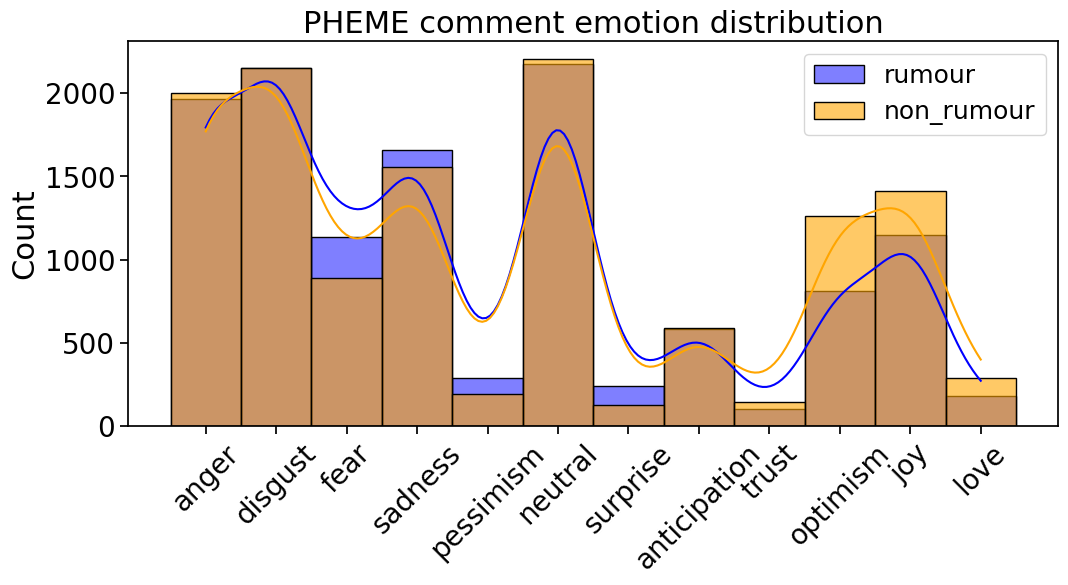

In [41]:
sns_plot2(df1=rumour_comments_emotion,df2=non_rumour_comments_emotion,size=(12,5),font_size=22,xlabels=EMO,
         title='PHEME comment emotion distribution',saveto='pheme_emotion_cmt.pdf')

# emotion stream analysis

In [42]:
# filter source tweet with more than N comments
n_comments=2

df=preprocess(pd.read_csv(filename,encoding='utf-8'))
df['id']=df['id'].astype(str)
src_tweets=df[~df['rumour_type'].str.endswith('reaction')]
src_tweets['n_comments']=src_tweets['structure'].apply(lambda x: collect_keys(x)).apply(lambda x: len(x))
src_tweets=src_tweets[src_tweets['n_comments']>=n_comments]

# sample same amount of cases for rumours and non-rumours
rumour=src_tweets[src_tweets['rumour_type']=='rumours']
non_rumour=src_tweets[src_tweets['rumour_type']=='non-rumours']

# sampling to balance data
sample_n=min(len(rumour),len(non_rumour))
rumour=rumour.sample(sample_n,random_state=2024)
non_rumour=non_rumour.sample(sample_n,random_state=2024)
print(f"rumour size:{len(rumour)}")
print(f"non rumour size:{len(non_rumour)}")

src_tweets=pd.concat([rumour,non_rumour])

rumour size:2691
non rumour size:2691


In [43]:
df_comments_original=[]
for i,(index, row) in tqdm(enumerate(src_tweets.iterrows()),total=len(src_tweets)):
    # print(row['rumour_type'])
    structure=row['structure']
    structure_keys = collect_keys(structure)
    df_thread = df[df['id'].isin(structure_keys)]
    df_thread['emollm_emotion']=df_thread['emollm_emotion'].apply(process_emotion)
    
    df_agg=pd.DataFrame({'id':df_thread.iloc[0]['id'],
                         'event':df_thread.iloc[0]['event'],
                         'timestamp_emotion':[df_thread['emollm_emotion'].to_list()],
                         'rumour_type':df_thread.iloc[0]['rumour_type'],
                         'factuality':df_thread.iloc[0]['factuality'],
                        })
    df_comments_original.append(df_agg)

100%|███████████████████████████████████████████████████| 5382/5382 [00:20<00:00, 263.00it/s]


In [45]:
df_comments=pd.concat(df_comments_original)

In [46]:
df_comments

,id,event,timestamp_emotion,rumour_type,factuality
0,552790371848040449,charliehebdo,"[[anger, disgust, fear], [anger, disgust], [an...",rumours,unverified
0,544332613532811264,sydneysiege,"[[anticipation, joy, optimism], [neutral], [ne...",rumours,true
0,500303431928922113,ferguson,"[[anger, disgust, sadness], [anger, disgust, s...",rumours,unverified
0,544385829180035072,sydneysiege,"[[neutral], [neutral], [neutral], [anger, disg...",rumours,true
0,500370960093302784,ferguson,"[[anger, disgust], [anger, disgust], [anger, d...",rumours,unverified
...,...,...,...,...,...
0,499568802267672576,ferguson,"[[anger, disgust, fear], [anger, disgust, surp...",non-rumours,NaN
0,500183912384319489,ferguson,"[[neutral], [neutral], [neutral], [neutral], [...",non-rumours,NaN
0,553590811355795456,charliehebdo,"[[anger, disgust, optimism], [neutral], [joy],...",non-rumours,NaN
0,498285405142540289,ferguson,"[[neutral], [neutral], [neutral], [neutral], [...",non-rumours,NaN


In [47]:
# group each thread emotion according to time interval
# each row in df_comments is a thread
df_comments['interval_emotion'] = df_comments.apply(
    lambda row: calculate_interval_emotions(row['timestamp_emotion'], 1), axis=1)

In [48]:
# select thread with at least n_intervals, so far we choose n_intervals=4
n_intervals=15
accum=True
df_time=df_comments[df_comments['interval_emotion'].apply(len)>=n_intervals]
df_time['interval_cnt']=df_time['interval_emotion'].apply(lambda row: count_interval_number(row)).apply(lambda row: cut_list(row,n_intervals))

In [52]:
rumour, non_rumour=get_labeled(df_time,True)
rumour_interval_emotions=get_timestep_emotions(rumour,n_intervals,'interval_emotion')
non_rumour_interval_emotions=get_timestep_emotions(non_rumour,n_intervals,'interval_emotion')
# normalize emotions
# rumour_interval_emotions=normalize_accum_emotions(rumour_interval_emotions)
# non_rumour_interval_emotions=normalize_accum_emotions(non_rumour_interval_emotions)

rumour size:1493
non rumour size:1493


<Figure size 1000x600 with 0 Axes>

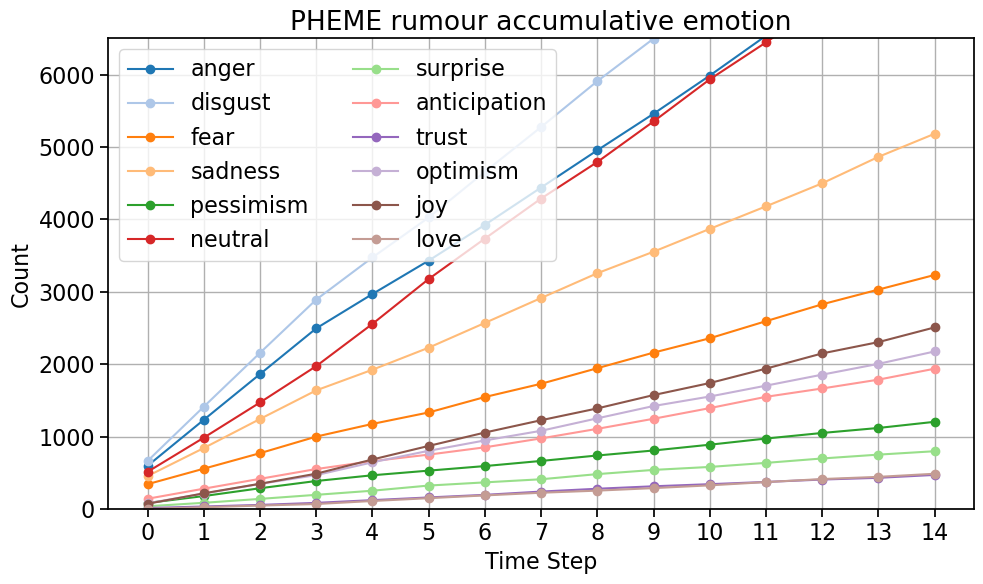

<Figure size 1000x600 with 0 Axes>

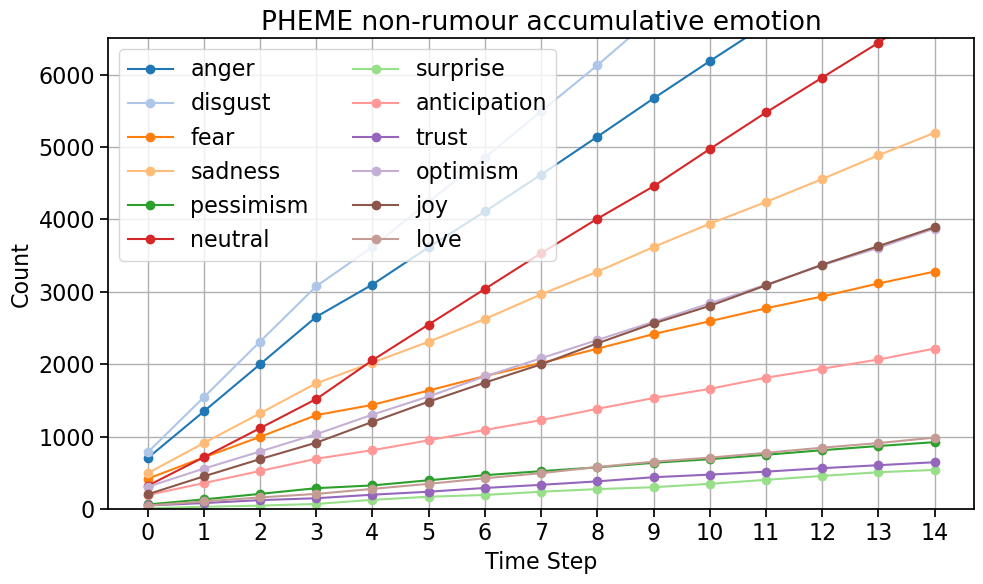

In [54]:
ru_acum=line_plot(rumour_interval_emotions,xlabel='Time Step',ylabel='Count',accum=accum,n_minutes=None, ylim=(0,6500),
          title=f'PHEME rumour accumulative emotion',saveto=f'pheme_rumour_accumulative.pdf')
non_acum=line_plot(non_rumour_interval_emotions,xlabel='Time Step',ylabel='Count',accum=accum,n_minutes=None, ylim=(0,6500),
          title=f'PHEME non-rumour accumulative emotion',saveto=f'pheme_non_accumulative.pdf')

In [55]:
# Combine rumour and non-rumour data into one DataFrame
def create_df(data, condition):
    emotion_data = []
    for emotion, values in data.items():
        emotion_data.append(pd.DataFrame({
            'x': values['x'],
            'y': values['y'],
            'emotion': emotion,
            'Condition': condition
        }))
    return pd.concat(emotion_data, ignore_index=True)

In [56]:
# Create DataFrames for rumour and non-rumour
ru_acum_df = create_df(ru_acum, 'rumour')
non_acum_df = create_df(non_acum, 'non-rumour')

# Combine rumour and non-rumour DataFrames
acum_df = pd.concat([ru_acum_df, non_acum_df], ignore_index=True)

# Create interaction term: x * Condition (1 if rumour, 0 if non-rumour)
acum_df['Condition'] = acum_df['Condition'].map({'rumour': 1, 'non-rumour': 0})
acum_df['x*Condition'] = acum_df['x'] * acum_df['Condition']

In [57]:
# Fit the model for each emotion
results = {}
for emotion in acum_df['emotion'].unique():
    emotion_data = acum_df[acum_df['emotion'] == emotion]
    
    # Define the independent variables (x, Condition, x*Condition) and dependent variable (y)
    X = emotion_data[['x', 'Condition', 'x*Condition']]
    X = sm.add_constant(X)  # Add constant for intercept
    y = emotion_data['y']
    
    # Fit the OLS regression model
    model = sm.OLS(y, X).fit()
    
    # Store results
    results[emotion] = model.summary()

In [58]:
# Print results for each emotion
for emotion, result in results.items():
    print(f"Results for {emotion}:\n")
    print(result)
    print("\n" + "="*50 + "\n")

Results for anger:

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     7927.
Date:                Wed, 04 Dec 2024   Prob (F-statistic):           1.32e-38
Time:                        11:43:06   Log-Likelihood:                -172.14
No. Observations:                  30   AIC:                             352.3
Df Residuals:                      26   BIC:                             357.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         908.0833     39.

# sentiments & emotion transition
- extract non-root pairwise emotions: return a list of (parent emotion, child emotion)
- extract root pairwise emotions: return a list of (root emotion, first layer node emotions)
- build count-based emotion transition matrix
- build masking emotion

In [61]:
# filter source tweet with more than N comments
n_comments=2

df=preprocess(pd.read_csv(filename,encoding='utf-8'))
df['id']=df['id'].astype(str)
df[sentiment_scheme]=df[sentiment_scheme].astype(str)
src_tweets=df[~df['rumour_type'].str.endswith('reaction')]
src_tweets['n_comments']=src_tweets['structure'].apply(lambda x: collect_keys(x)).apply(lambda x: len(x))
src_tweets=src_tweets[src_tweets['n_comments']>=n_comments]

# sample same amount of cases for rumours and non-rumours
rumour=src_tweets[src_tweets['rumour_type']=='rumours']
non_rumour=src_tweets[src_tweets['rumour_type']=='non-rumours']

# sampling to balance data
sample_n=min(len(rumour),len(non_rumour))
rumour=rumour.sample(sample_n,random_state=2024)
non_rumour=non_rumour.sample(sample_n,random_state=2024)
print(f"rumour size:{len(rumour)}")
print(f"non rumour size:{len(non_rumour)}")

src_tweets=pd.concat([rumour,non_rumour])

rumour size:2691
non rumour size:2691


In [62]:
df_comments_original=[]
# thread or time
pairwise_type='time'
n_gram=5
for index, row in tqdm(src_tweets.iterrows(),total=src_tweets.shape[0]):
    # print(row['rumour_type'])
    structure=row['structure']
    structure_keys = collect_keys(structure)
    df_thread = df[df['id'].isin(structure_keys)]
    df_thread=df_thread.drop_duplicates(subset=['id'], keep='first')
    # df_thread[emotion_scheme]=df_thread[emotion_scheme].apply(process_emotion,primary=False)
    df_thread['created_at']=df_thread['created_at'].apply(format_time)
    df_thread.sort_values(by='created_at',inplace=True)

    # aggregate information for one thread
    agg_dict={
        'id':df_thread.iloc[0]['id'],
        'event':df_thread.iloc[0]['event'],
        'rumour_type':df_thread.iloc[0]['rumour_type'],
        'factuality':df_thread.iloc[0]['factuality'],
    }
    # extract N-gram affective info (the first in N-gram should be aff in source tweet)
    if 'n_gram' in pairwise_type:
        df_thread[emotion_scheme]=df_thread[emotion_scheme].apply(process_emotion,primary=True)
        n_gram_id=timestamp_n_gram(df_thread['id'].to_list(),n_gram,False)
        n_gram_emo=get_aff_from_id(df_thread,n_gram_id,emotion_scheme)
        agg_dict.update({
            'n_gram_pairs_id':[n_gram_id],
            'n_gram_pairs_emo':[n_gram_emo],
        })

    # extract pair affective info chronologically
    if 'time' in pairwise_type:
        df_thread[emotion_scheme]=df_thread[emotion_scheme].apply(process_emotion,primary=False)
        
        df_thread=df_thread[df_thread['structure'].str.endswith('reaction')] # exclude the root tweet
        
        time_pairs_id=timestamp_pairwise(df_thread['id'].to_list())
        time_pairs_emo=get_emo_from_id(df_thread,time_pairs_id)
        time_pairs_emo=product_pairs(time_pairs_emo)
        time_pairs_sent=get_sent_from_id(df_thread,time_pairs_id)
        agg_dict.update({
            'time_pairs_id':[time_pairs_id],
            'time_pairs_emo':[time_pairs_emo],
            'time_pairs_sent':[time_pairs_sent],
        })
        
    # extract pair affective info based on tree structure
    if 'thread' in pairwise_type:
        df_thread[emotion_scheme]=df_thread[emotion_scheme].apply(process_emotion,primary=False)
        # extract pariwise ids, (parent, child) comes from structure
        _, non_root_pairs, root_pairs=bfs_tree_pairwise(structure)
        
        # extract pairwise emotions from ids
        root_pairs_emo=get_emo_from_id(df_thread,root_pairs)
        non_root_pairs_emo=get_emo_from_id(df_thread,non_root_pairs)
        # product pairs
        root_pairs_emo=product_pairs(root_pairs_emo)
        non_root_pairs_emo=product_pairs(non_root_pairs_emo)
    
        # extract pairwise sentiments from ids
        root_pairs_sent=get_sent_from_id(df_thread,root_pairs)
        non_root_pairs_sent=get_sent_from_id(df_thread,non_root_pairs)
        agg_dict.update({
            'root_pairs_id':[root_pairs],
            'non_root_pairs_id':[non_root_pairs],
            'root_pairs_emo':[root_pairs_emo],
            'non_root_pairs_emo':[non_root_pairs_emo],
            'root_pairs_sent':[root_pairs_sent],
            'non_root_pairs_sent':[non_root_pairs_sent],
        })
    
    df_agg=pd.DataFrame(agg_dict)
    df_comments_original.append(df_agg)
    # break
df_comments=pd.concat(df_comments_original)

100%|████████████████████████████████████████████████████| 5382/5382 [01:17<00:00, 69.41it/s]


In [9]:
df_comments.head()

,id,event,rumour_type,factuality,time_pairs_id,time_pairs_emo,time_pairs_sent
0,500388199064420352,ferguson,rumours,unverified,"[(500388380572909568, 500388648408600576), (50...","[(neutral, neutral), (neutral, joy), (neutral,...","[(0, -1), (-1, 2), (2, -1), (-1, 0), (0, -1), ..."
0,525052332116312064,ottawashooting,rumours,unverified,"[(525052566665588736, 525054640967004160), (52...","[(joy, joy), (joy, optimism), (joy, trust), (l...","[(1, 1), (1, 0), (0, 0), (0, -2), (-2, 0)]"
0,553531316797718528,charliehebdo,rumours,unverified,"[(553531501703614464, 553531673196122112), (55...","[(anger, fear), (disgust, fear), (fear, fear),...","[(-2, -2), (-2, -2), (-2, 0), (0, 0), (0, -2)]"
0,500358907383275520,ferguson,rumours,unverified,"[(500359416919908352, 500359485144059904), (50...","[(anger, disgust), (disgust, disgust), (sadnes...","[(-2, 0), (0, 0), (0, 0), (0, 0), (0, -2), (-2..."
0,524987432656453632,ottawashooting,rumours,true,"[(524987483961176064, 524987562851827713), (52...","[(anger, anticipation), (anger, joy), (anger, ...","[(-2, 1), (1, 0), (0, 0), (0, 0), (0, -3), (-3..."


In [63]:
rumour, non_rumour=get_labeled(df_comments,False)

rumour size:2691
non rumour size:2691


In [64]:
true, false, unverified= get_factuality(df_comments,True)

true size:505
false size:505
unverified size:505


## emotion transition (time)

In [80]:
# rumour and non rumour emotion
sample_size=0
no_neutral=False
is_log=False
ru_root=get_emo_pairs(rumour,'time_pairs_emo',no_neutral,sample_size)
non_root=get_emo_pairs(non_rumour,'time_pairs_emo',no_neutral,sample_size)

time_pairs_emo pair size: 141368
time_pairs_emo pair size: 179757


In [81]:
def normalize_emotion_pairs(emotion_pairs:List):
    return [(normalize_emotion(from_emo),normalize_emotion(to_emo)) for from_emo,to_emo in emotion_pairs]

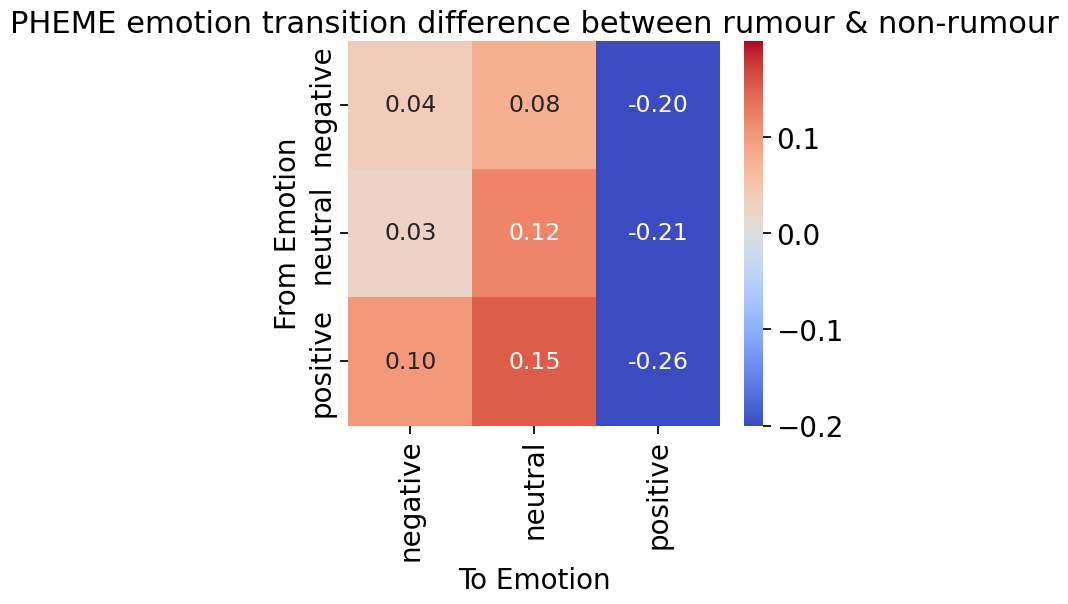

In [82]:
# original emotions
vmax=0.2
vmin=-0.2
font_size=16
_,ru_root_matrix=create_pure_matrix(normalize_emotion_pairs(ru_root),'emo_agg',no_neutral,is_log,'pheme_rumour_transition',vmax,vmin)
_,non_root_matrix=create_pure_matrix(normalize_emotion_pairs(non_root),'emo_agg',no_neutral,is_log,'pheme_non_transition',vmax,vmin)
diff_root=(ru_root_matrix-non_root_matrix)/ru_root_matrix

plot_matrix(matrix=diff_root,aff='emo_agg',no_neutral=False,font_size=20,vmax=vmax,vmin=vmin, annot=diff_root, fig_size=(6,5),
            title='PHEME emotion transition difference between rumour & non-rumour')

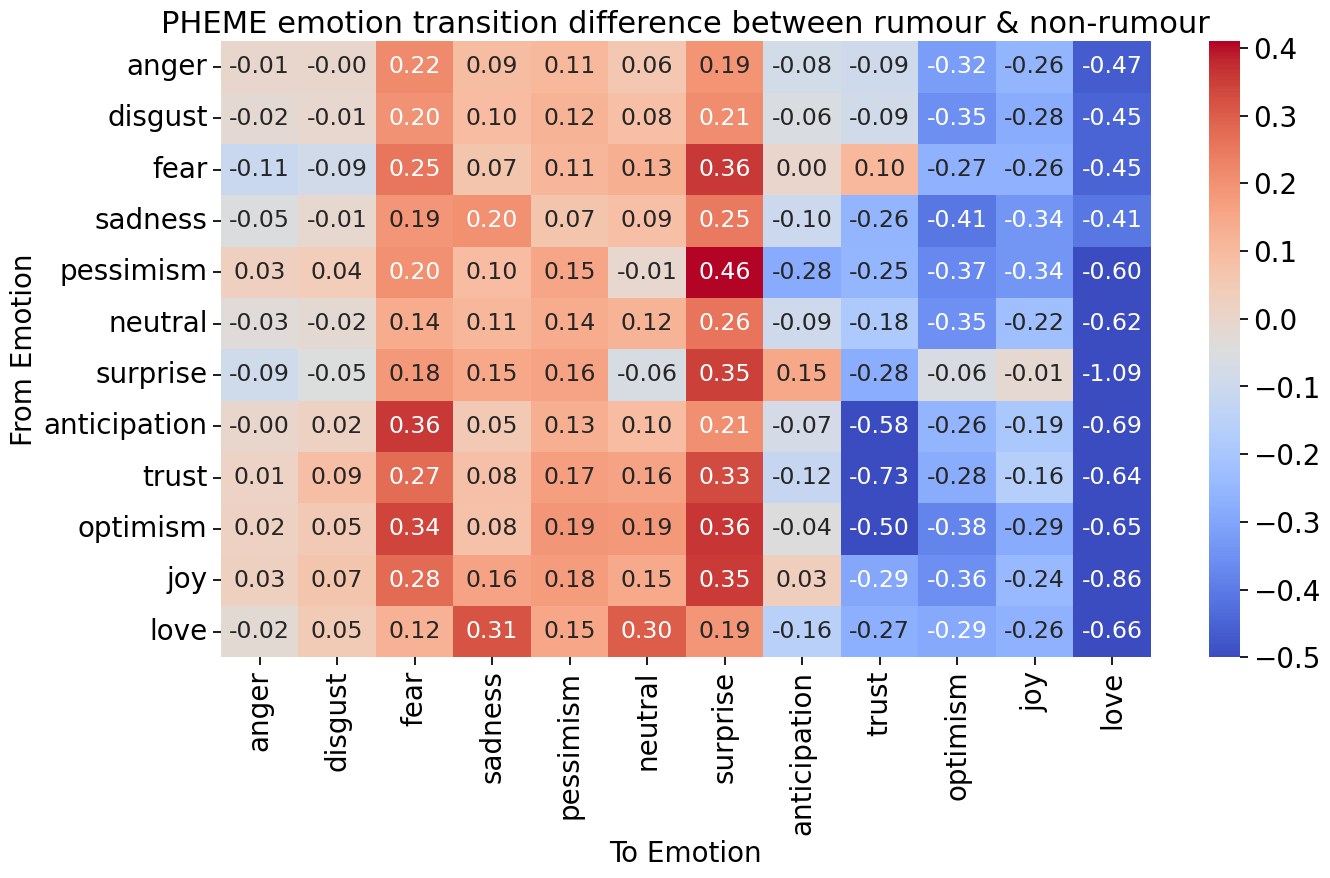

In [83]:
# original emotions
vmax=0.41
vmin=-0.5
font_size=16
_,ru_root_matrix=create_pure_matrix(ru_root,'emo',no_neutral,is_log,'pheme_rumour_transition',vmax,vmin)
_,non_root_matrix=create_pure_matrix(non_root,'emo',no_neutral,is_log,'pheme_non_transition',vmax,vmin)
diff_root=(ru_root_matrix-non_root_matrix)/ru_root_matrix

plot_matrix(matrix=diff_root,aff='emo',no_neutral=no_neutral,font_size=20,vmax=vmax,vmin=vmin, annot=diff_root, fig_size=(15,8),
            title='PHEME emotion transition difference between rumour & non-rumour',saveto='pheme_diff_transition_noroot.pdf')

In [ ]:
# rumour vs non rumour root
vmax=0.29
vmin=0
font_size=16
create_matrix(ru_root,'emo',no_neutral,is_log,'pheme_rumour_transition',vmax,vmin)
create_matrix(non_root,'emo',no_neutral,is_log,'pheme_non_transition',vmax,vmin)

In [70]:
# true, false and unverified emotion
sample_size=0
true_root=get_emo_pairs(true,'time_pairs_emo',no_neutral,sample_size)
false_root=get_emo_pairs(false,'time_pairs_emo',no_neutral,sample_size)
unverified_root=get_emo_pairs(unverified,'time_pairs_emo',no_neutral,sample_size)

time_pairs_emo pair size: 23824
time_pairs_emo pair size: 17747
time_pairs_emo pair size: 33196


In [ ]:
# true, false and unverified branch
vmax=0.31
vmin=0

create_matrix(true_root,'emo',no_neutral,is_log,'pheme_true_transition',vmax,vmin)
create_matrix(false_root,'emo',no_neutral,is_log,'pheme_false_transition',vmax,vmin)
create_matrix(unverified_root,'emo',no_neutral,is_log,'pheme_unverified_transition',vmax,vmin)

In [ ]:
# rumour and non rumour emotion
sample_size=0
no_neutral=True
is_log=False
ru_root=get_sent_pairs(rumour,'root_pairs_sent',sample_size)
ru_branch=get_sent_pairs(rumour,'non_root_pairs_sent',sample_size)
non_root=get_sent_pairs(non_rumour,'root_pairs_sent',sample_size)
non_branch=get_sent_pairs(non_rumour,'non_root_pairs_sent',sample_size)

In [ ]:
# rumour vs non rumour root
vmax=0.60
vmin=0
create_matrix(ru_root,'sent',no_neutral,is_log,'Rumour Root Sentiment Transition Matrix (Tree)',vmax,vmin)
create_matrix(non_root,'sent',no_neutral,is_log,'Non Rumour Root Sentiment Transition Matrix (Tree)',vmax,vmin)

In [ ]:
# rumour vs non rumour branch
create_matrix(ru_branch,'sent',no_neutral,is_log,'Rumour Branch Sentiment Transition Matrix (Tree)',vmax,vmin)
create_matrix(non_branch,'sent',no_neutral,is_log,'Non Rumour Branch Sentiment Transition Matrix (Tree)',vmax,vmin)

In [504]:
# true, false and unverified emotion
sample_size=0
true_root=get_sent_pairs(true,pair_type='root_pairs_sent',n_sample=sample_size)
false_root=get_sent_pairs(false,pair_type='root_pairs_sent',n_sample=sample_size)
unverified_root=get_sent_pairs(unverified,pair_type='root_pairs_sent',n_sample=sample_size)

true_branch=get_sent_pairs(true,pair_type='non_root_pairs_sent',n_sample=sample_size)
false_branch=get_sent_pairs(false,pair_type='non_root_pairs_sent',n_sample=sample_size)
unverified_branch=get_sent_pairs(unverified,pair_type='non_root_pairs_sent',n_sample=sample_size)

root_pairs_sent pair size: 187
root_pairs_sent pair size: 156
root_pairs_sent pair size: 374
non_root_pairs_sent pair size: 324
non_root_pairs_sent pair size: 286
non_root_pairs_sent pair size: 367


In [ ]:
# true, false and unverified root
vmax=0.72
vmin=0
create_matrix(true_root,'sent',no_neutral,is_log,'True Root Sentiment Transition Matrix (Tree)',vmax,vmin)
create_matrix(false_root,'sent',no_neutral,is_log,'False Root Sentiment Transition Matrix (Tree)',vmax,vmin)
create_matrix(unverified_root,'sent',no_neutral,is_log,'Unverified Root Sentiment Transition Matrix (Tree)',vmax,vmin)

In [ ]:
# true, false and unverified branch
vmax=0.65
create_matrix(true_branch,'sent',no_neutral,is_log,'True Branch Sentiment Transition Matrix (Tree)',vmax,vmin)
create_matrix(false_branch,'sent',no_neutral,is_log,'False Branch Sentiment Transition Matrix (Tree)',vmax,vmin)
create_matrix(unverified_branch,'sent',no_neutral,is_log,'Unverified Branch Sentiment Transition Matrix (Tree)',vmax,vmin)

## emotion transition (tree)

### delta

In [174]:
# rumour and non rumour emotion
sample_size=0
no_neutral=True
is_log=False
ru_root=get_emo_pairs(rumour,'root_pairs_emo',no_neutral,sample_size)
ru_branch=get_emo_pairs(rumour,'non_root_pairs_emo',no_neutral,sample_size)
non_root=get_emo_pairs(non_rumour,'root_pairs_emo',no_neutral,sample_size)
non_branch=get_emo_pairs(non_rumour,'non_root_pairs_emo',no_neutral,sample_size)

root_pairs_emo pair size: 50716
non_root_pairs_emo pair size: 26820
root_pairs_emo pair size: 153554
non_root_pairs_emo pair size: 82308


In [191]:
from utils import *

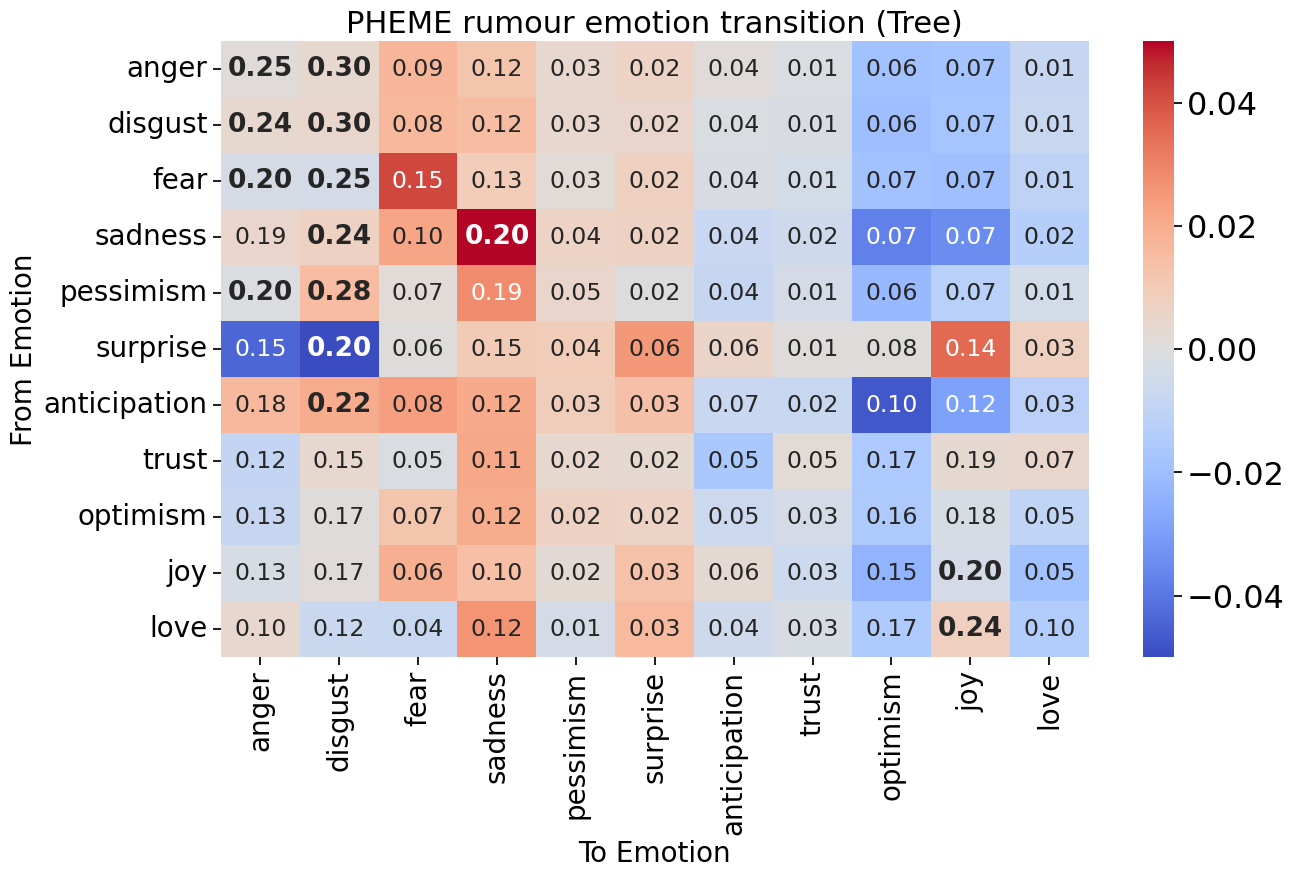

In [192]:
# all pairs
vmax=0.05
vmin=-0.05
font_size=16

all_ru=ru_root+ru_branch
all_non=non_root+non_branch

_,ru_matrix=create_pure_matrix(all_ru,'emo',no_neutral,is_log,'pheme_rumour_transition',vmax,vmin)
_,non_matrix=create_pure_matrix(all_non,'emo',no_neutral,is_log,'pheme_non_transition',vmax,vmin)

diff=ru_matrix-non_matrix

plot_matrix(matrix=diff,aff='emo',no_neutral=True,font_size=20,vmax=vmax,vmin=vmin,annot=ru_matrix,
            title='PHEME rumour emotion transition (Tree)',saveto='pheme_diff_transition_tree_delta.pdf')

# plot_matrix(matrix=ru_matrix,aff='emo',no_neutral=True,font_size=20,vmax=vmax,vmin=vmin,annot=diff,
#             title='PHEME rumour emotion transition (Tree)',saveto='pheme_diff_transition_tree_origin.pdf')

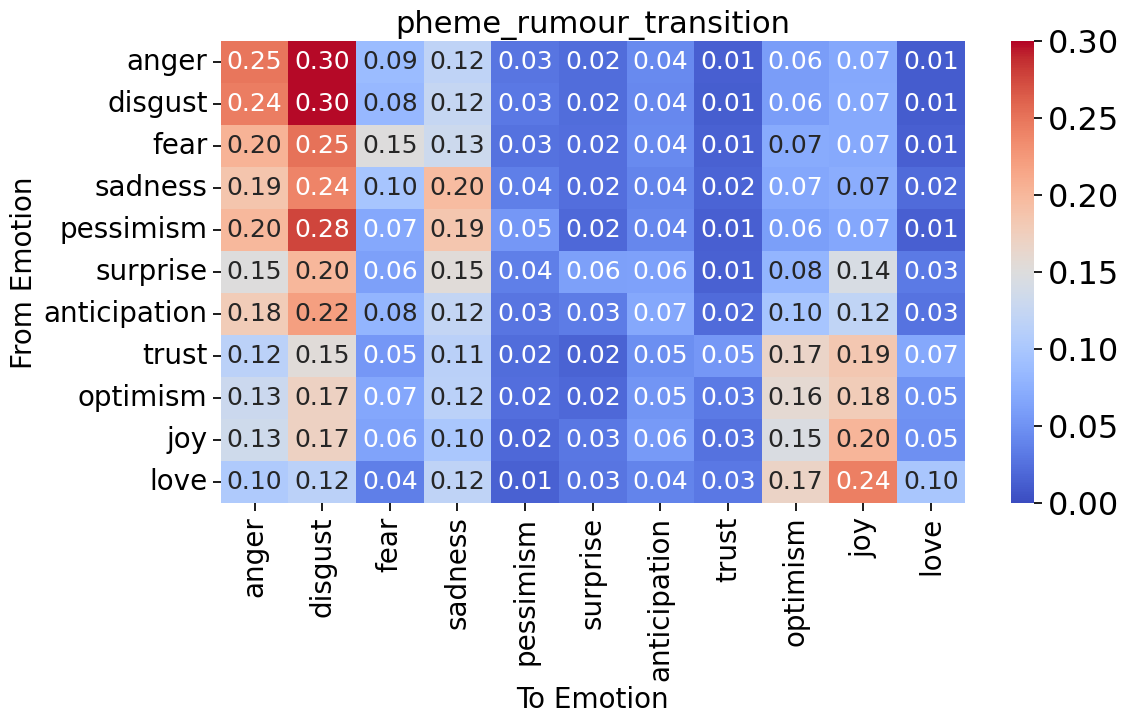

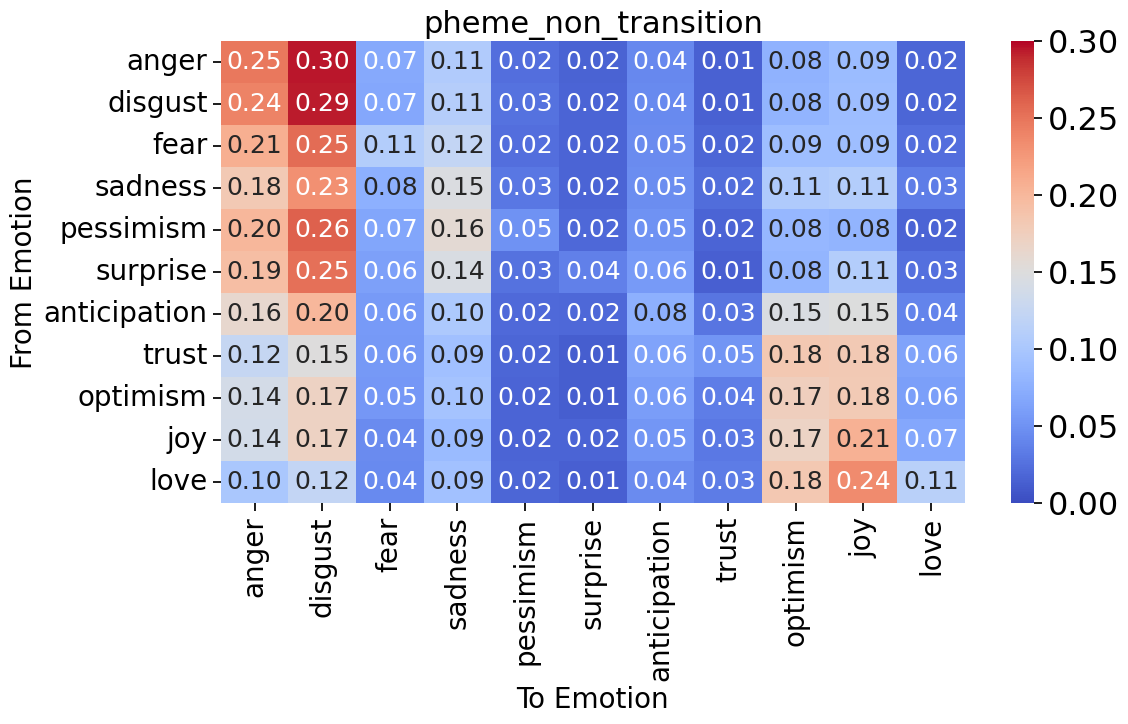

In [155]:
vmax=0.30
vmin=-0.00
font_size=16
all_ru=ru_root+ru_branch
all_non=non_root+non_branch
create_matrix(all_ru,'emo',no_neutral,is_log,'pheme_rumour_transition',vmax,vmin)
create_matrix(all_non,'emo',no_neutral,is_log,'pheme_non_transition',vmax,vmin)

### original

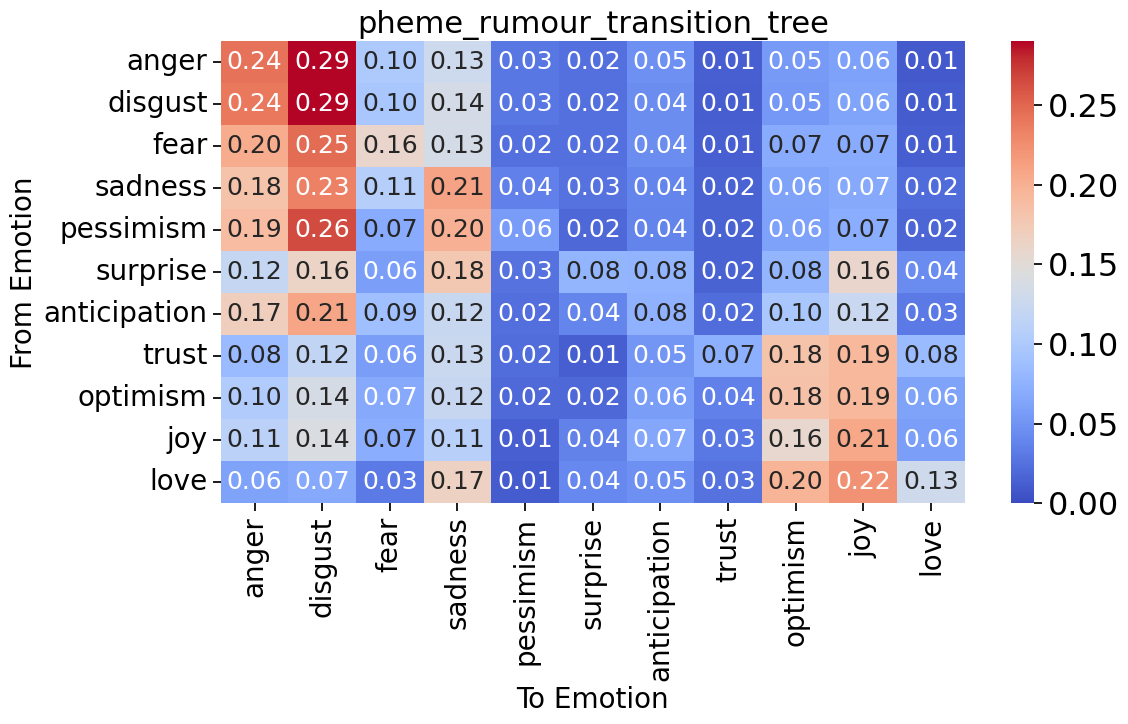

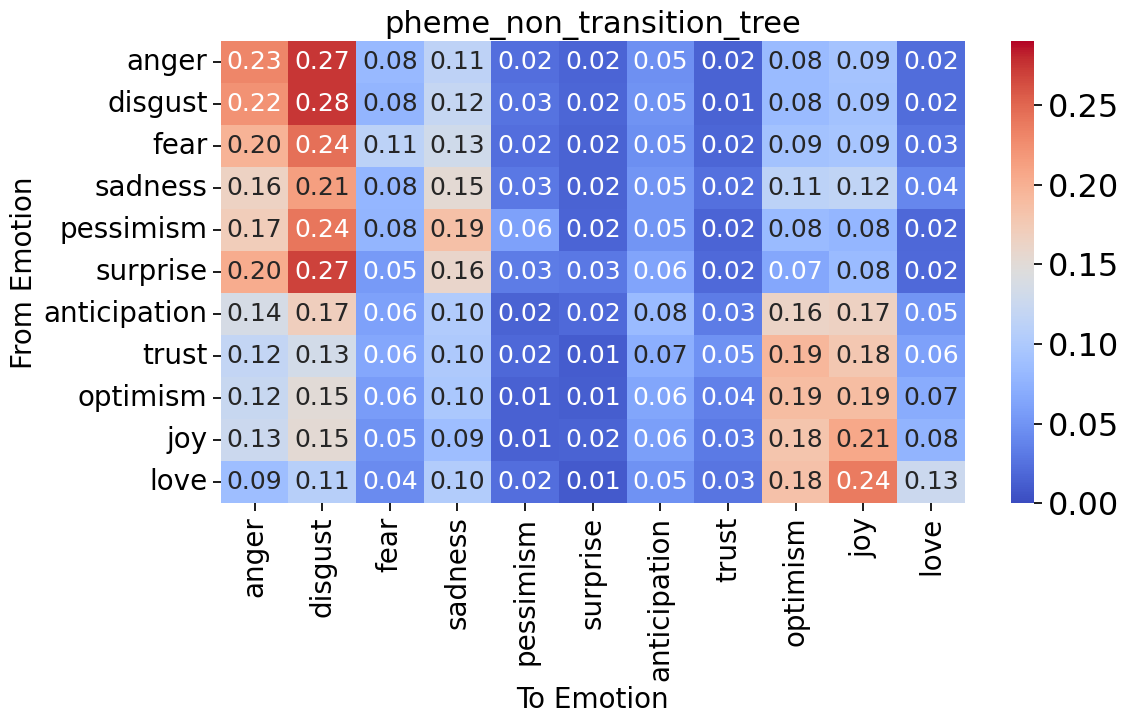

In [65]:
# rumour vs non rumour root
vmax=0.29
create_matrix(ru_root,'emo',no_neutral,is_log,'pheme_rumour_transition_tree',vmax,vmin)
create_matrix(non_root,'emo',no_neutral,is_log,'pheme_non_transition_tree',vmax,vmin)

In [66]:
# rumour vs non rumour branch
# vmax=0.32
# create_matrix(ru_branch,'emo',no_neutral,is_log,'Rumour Branch Emotion Transition Matrix (Tree)',vmax,vmin)
# create_matrix(non_branch,'emo',no_neutral,is_log,'Non Rumour Branch Emotion Transition Matrix (Tree)',vmax,vmin)

In [67]:
# true, false and unverified emotion
sample_size=0
true_root=get_emo_pairs(true,pair_type='root_pairs_emo',n_sample=sample_size)
false_root=get_emo_pairs(false,pair_type='root_pairs_emo',n_sample=sample_size)
unverified_root=get_emo_pairs(unverified,pair_type='root_pairs_emo',n_sample=sample_size)

true_branch=get_emo_pairs(true,pair_type='non_root_pairs_emo',n_sample=sample_size)
false_branch=get_emo_pairs(false,pair_type='non_root_pairs_emo',n_sample=sample_size)
unverified_branch=get_emo_pairs(unverified,pair_type='non_root_pairs_emo',n_sample=sample_size)

root_pairs_emo pair size: 10744
root_pairs_emo pair size: 7246
root_pairs_emo pair size: 16503
non_root_pairs_emo pair size: 6555
non_root_pairs_emo pair size: 4140
non_root_pairs_emo pair size: 7945


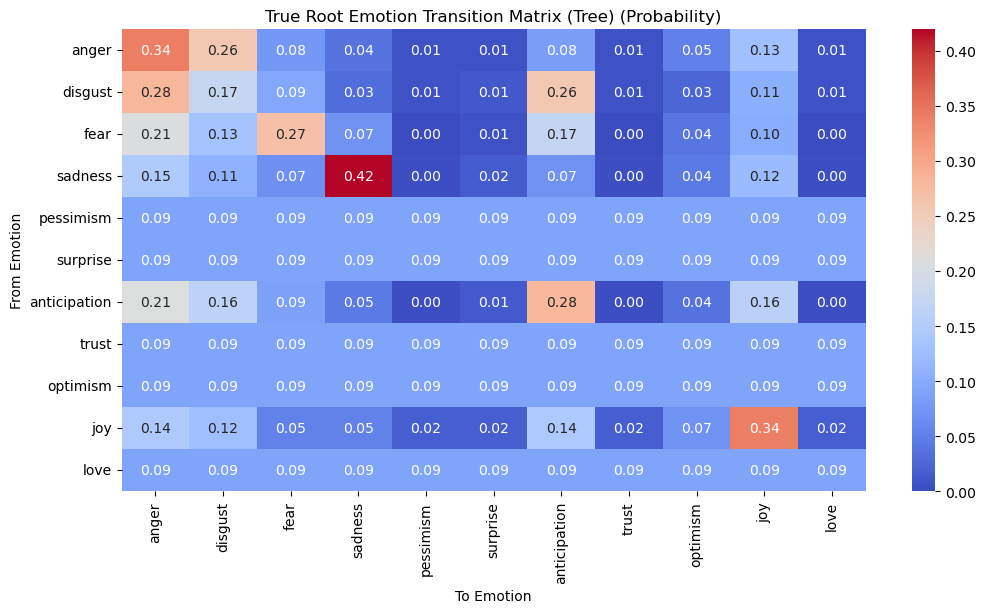

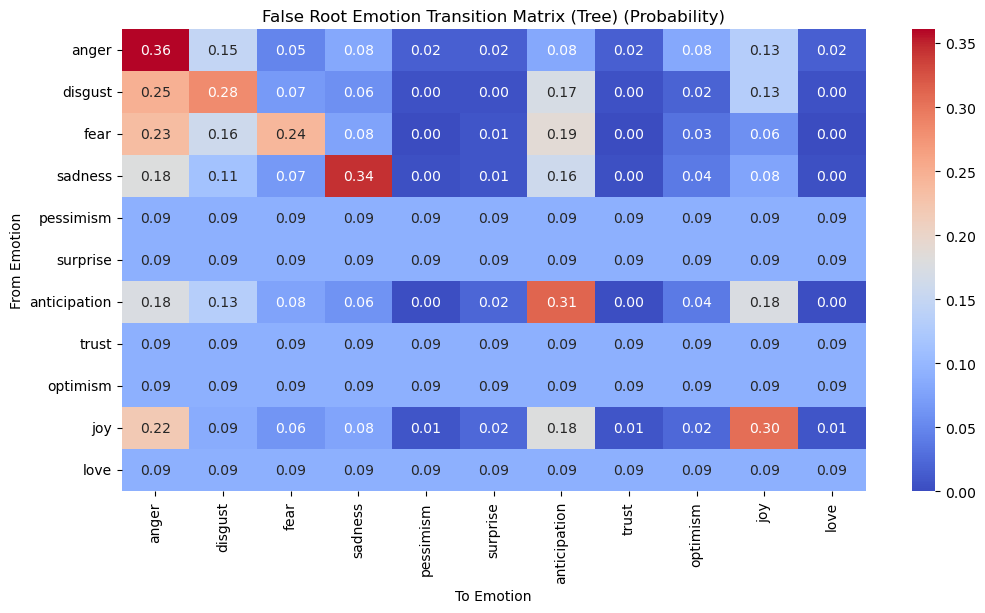

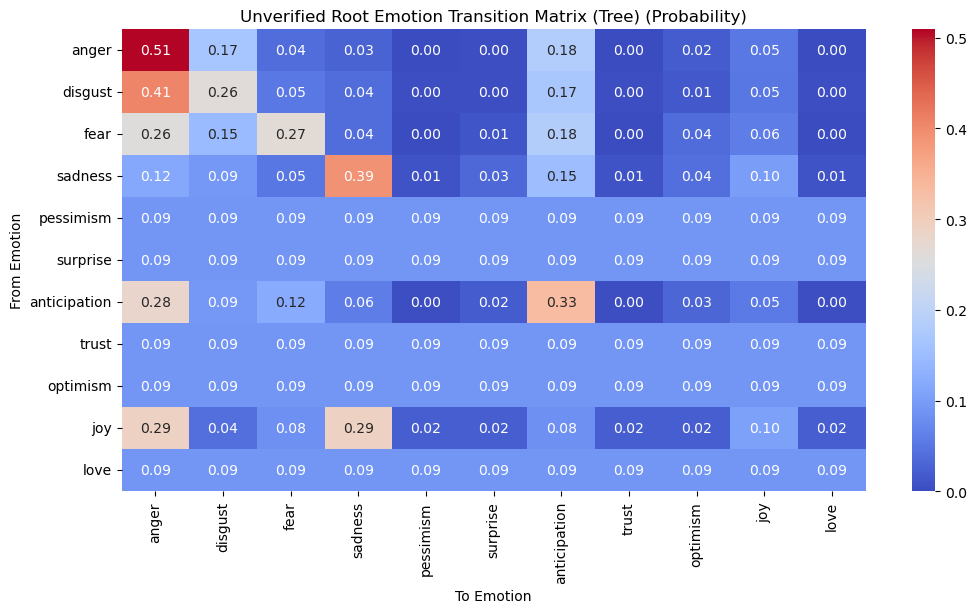

In [513]:
# true, false and unverified root
vmax=0.30
create_matrix(true_root,'emo',no_neutral,is_log,'True Root Emotion Transition Matrix (Tree)',vmax,vmin)
create_matrix(false_root,'emo',no_neutral,is_log,'False Root Emotion Transition Matrix (Tree)',vmax,vmin)
create_matrix(unverified_root,'emo',no_neutral,is_log,'Unverified Root Emotion Transition Matrix (Tree)',vmax,vmin)

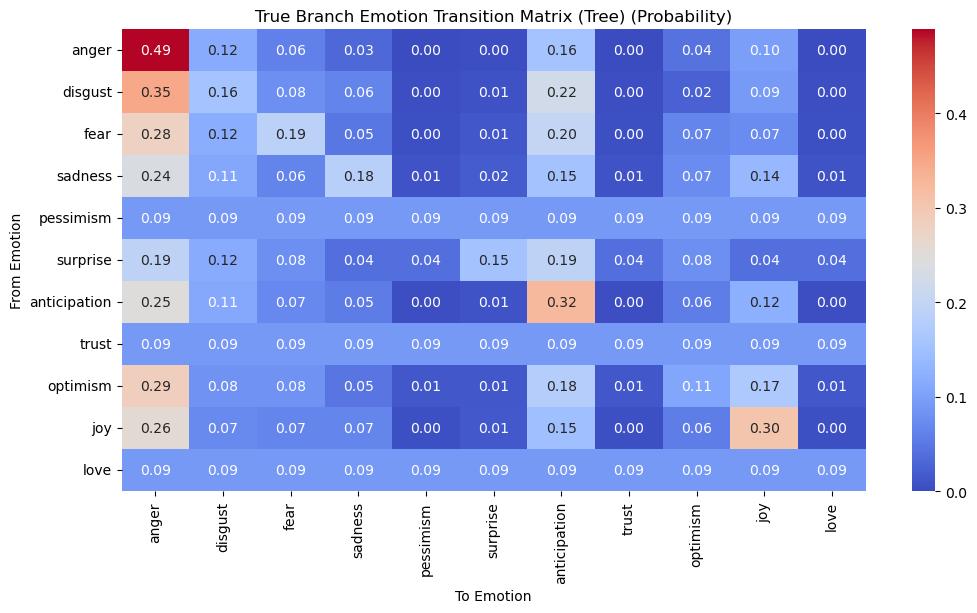

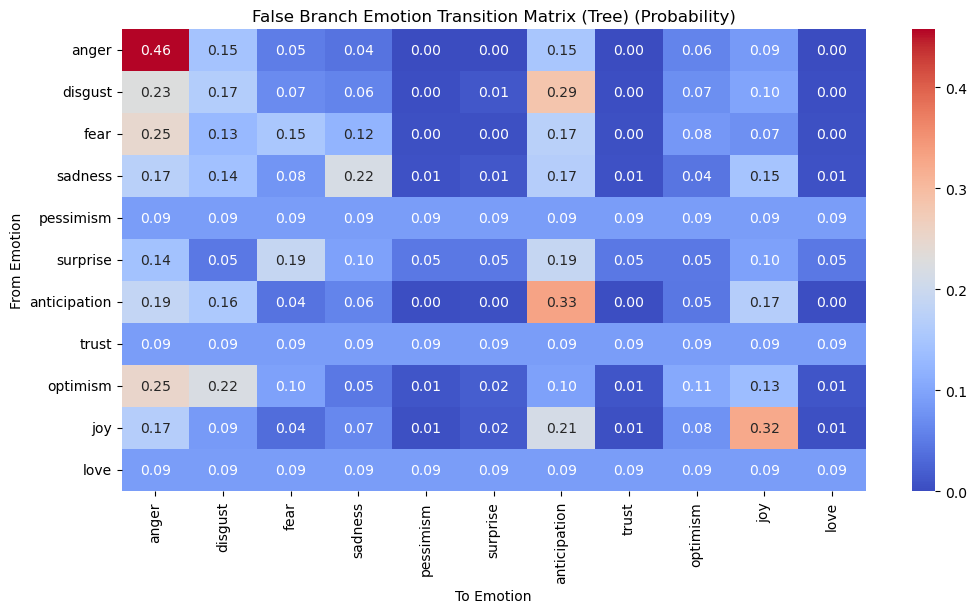

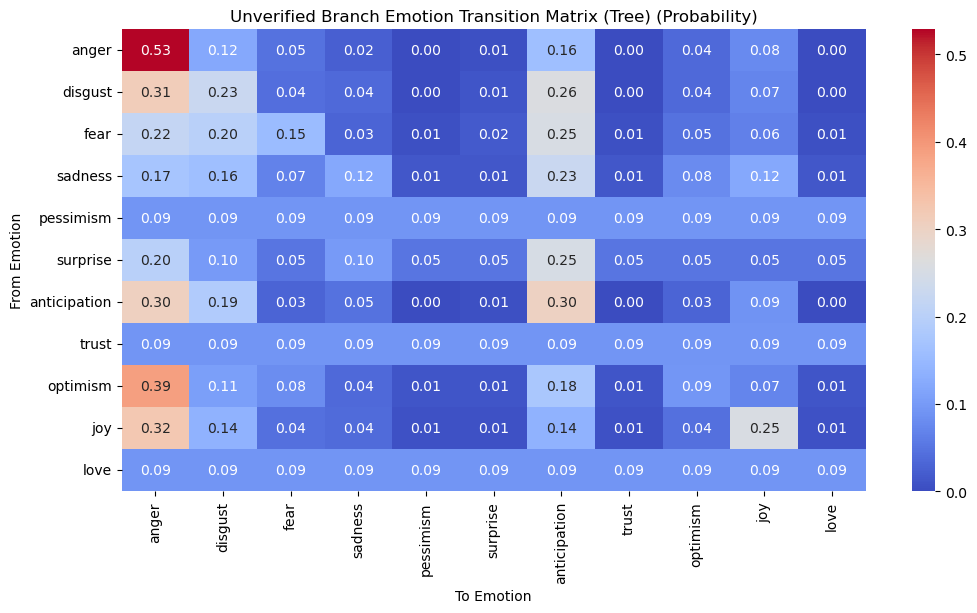

In [515]:
# true, false and unverified branch
vmax=0.32
create_matrix(true_branch,'emo',no_neutral,is_log,'True Branch Emotion Transition Matrix (Tree)',vmax,vmin)
create_matrix(false_branch,'emo',no_neutral,is_log,'False Branch Emotion Transition Matrix (Tree)',vmax,vmin)
create_matrix(unverified_branch,'emo',no_neutral,is_log,'Unverified Branch Emotion Transition Matrix (Tree)',vmax,vmin)